In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

# Transformers

## Chargement des Données

In [38]:
# Données d'entrainement
train_data_complete = pd.read_csv("../data/allocine_genres_train.csv", sep=",")
train_data = train_data_complete[["titre", "synopsis", "genre"]]

# Données de test/validation
test_data_complete = pd.read_csv("../data/allocine_genres_test.csv", sep=",")
test_data = test_data_complete[["titre", "synopsis", "genre"]]

In [39]:
# Liste de classes et ajout d'un identifiant numérique pour chaque classe
genre_name = sorted(train_data.genre.unique().flatten())
print("Genres:", genre_name)
print("Nombre d'exemplaires:", len(train_data))

label2id = {genre_name[i]:i for i in range(len(genre_name))}
id2label = {i:genre_name[i] for i in range(len(genre_name))}

Genres: ['biopic', 'comédie', 'documentaire', 'drame', 'historique', 'horreur', 'policier', 'romance', 'science fiction']
Nombre d'exemplaires: 2875


In [40]:
# Paramètres
batch_size = 64
# Proportion des données qui sera utilisée
scale = 0.2

In [41]:
from datasets import Features, Value, ClassLabel, Dataset, DatasetDict

data_df = pd.DataFrame()
# Chaque film est décrit par un titre et un synopsis
split_titre = train_data.titre
data_df["text"] = split_titre + " " + train_data.synopsis
# Chaque filme possède un attribut qui décrit son genre (auquel a été associé un identifiant numérique)
data_df["genre"] = train_data.genre.map(label2id)

# Transformation du DataFrame en objet de type Dataset utilisé par HuggingFace
province_features = Features({"text": Value('string'),
                              "genre": ClassLabel(names=genre_name)})
data = Dataset.from_pandas(data_df, features=province_features)
# Découpage en train et test
data = data.train_test_split(test_size=0.2, shuffle=True, seed=12)

In [42]:
data["train"].features

{'text': Value(dtype='string', id=None),
 'genre': ClassLabel(names=['biopic', 'comédie', 'documentaire', 'drame', 'historique', 'horreur', 'policier', 'romance', 'science fiction'], id=None)}

In [43]:
data["train"][0]

{'text': "True Romance Le jour de son anniversaire , Clarence Worley rencontre la splendide Alabama dans un cinéma miteux . Coup de foudre immédiat . Après une nuit d' amour , Alabama avoue a Clarence qu' elle a été en fait engagée par le patron de Clarence comme cadeau d' anniversaire . De là va commencer une folle aventure .",
 'genre': 7}

## Tokénisation

In [44]:
from transformers import AutoTokenizer

model_ckpt = "camembert-base"
# Chargement du tokéniseur pré-entraîné correspondant au modèle utilisé
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [46]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

In [47]:
# Tokénisation des 2 premières instances
preprocess_function(data["train"][:2])

{'input_ids': [[5, 10205, 35, 6900, 291, 54, 209, 8, 58, 2575, 21, 7, 15195, 2101, 692, 451, 2404, 162, 13, 11072, 114, 10966, 4547, 29, 23, 1545, 4189, 914, 21, 9, 8207, 8, 13268, 8567, 21, 9, 407, 28, 656, 18, 11, 1724, 21, 7, 114, 10966, 4547, 16102, 33, 15195, 2101, 46, 11, 109, 33, 101, 22, 82, 8158, 37, 16, 3656, 8, 15195, 2101, 79, 2275, 18, 11, 2575, 21, 9, 137, 241, 198, 1348, 28, 5907, 3371, 21, 9, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [5, 10094, 4164, 10094, 4164, 21, 7, 338, 134, 21, 7, 27406, 422, 37, 89, 27193, 10, 21, 7, 2656, 15, 58, 2377, 22, 1299, 8, 48, 8840, 8, 58, 17806, 8, 64, 1835, 94, 21, 9, 123, 10672, 108, 16, 12750, 20, 6224, 3446, 21, 7, 109, 82, 16, 10242, 42, 77, 1058, 2940, 8, 1077, 42, 16, 246, 2635, 31, 11156, 13, 438, 8, 13, 1010, 21, 9, 28222, 8, 4532, 21, 7, 44, 2635, 52, 12, 21, 6559, 98, 19216, 21, 7, 16, 40, 6

In [48]:
# Tokenisation de la totalité des données : chaque unité est remplacée par un identifiant numérique
tokenized_data = data.map(preprocess_function, batched=True, batch_size=None)

Map:   0%|          | 0/2300 [00:00<?, ? examples/s]

Map:   0%|          | 0/575 [00:00<?, ? examples/s]

In [49]:
tokenized_data["train"][0]

{'text': "True Romance Le jour de son anniversaire , Clarence Worley rencontre la splendide Alabama dans un cinéma miteux . Coup de foudre immédiat . Après une nuit d' amour , Alabama avoue a Clarence qu' elle a été en fait engagée par le patron de Clarence comme cadeau d' anniversaire . De là va commencer une folle aventure .",
 'genre': 7,
 'input_ids': [5,
  10205,
  35,
  6900,
  291,
  54,
  209,
  8,
  58,
  2575,
  21,
  7,
  15195,
  2101,
  692,
  451,
  2404,
  162,
  13,
  11072,
  114,
  10966,
  4547,
  29,
  23,
  1545,
  4189,
  914,
  21,
  9,
  8207,
  8,
  13268,
  8567,
  21,
  9,
  407,
  28,
  656,
  18,
  11,
  1724,
  21,
  7,
  114,
  10966,
  4547,
  16102,
  33,
  15195,
  2101,
  46,
  11,
  109,
  33,
  101,
  22,
  82,
  8158,
  37,
  16,
  3656,
  8,
  15195,
  2101,
  79,
  2275,
  18,
  11,
  2575,
  21,
  9,
  137,
  241,
  198,
  1348,
  28,
  5907,
  3371,
  21,
  9,
  6,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


In [50]:
# Affichage des tokens. DistilBERT utilise l'algorithme WordPiece
tokens = tokenizer.convert_ids_to_tokens(tokenized_data["train"][0]['input_ids'])
print(tokenized_data["train"][0]["text"])
print(tokens)

True Romance Le jour de son anniversaire , Clarence Worley rencontre la splendide Alabama dans un cinéma miteux . Coup de foudre immédiat . Après une nuit d' amour , Alabama avoue a Clarence qu' elle a été en fait engagée par le patron de Clarence comme cadeau d' anniversaire . De là va commencer une folle aventure .
['<s>', '▁Tru', 'e', '▁Roman', 'ce', '▁Le', '▁jour', '▁de', '▁son', '▁anniversaire', '▁', ',', '▁Clar', 'ence', '▁W', 'or', 'ley', '▁rencontre', '▁la', '▁splendide', '▁A', 'lab', 'ama', '▁dans', '▁un', '▁cinéma', '▁mit', 'eux', '▁', '.', '▁Coup', '▁de', '▁foudre', '▁immédiat', '▁', '.', '▁Après', '▁une', '▁nuit', '▁d', "'", '▁amour', '▁', ',', '▁A', 'lab', 'ama', '▁avoue', '▁a', '▁Clar', 'ence', '▁qu', "'", '▁elle', '▁a', '▁été', '▁en', '▁fait', '▁engagée', '▁par', '▁le', '▁patron', '▁de', '▁Clar', 'ence', '▁comme', '▁cadeau', '▁d', "'", '▁anniversaire', '▁', '.', '▁De', '▁là', '▁va', '▁commencer', '▁une', '▁folle', '▁aventure', '▁', '.', '</s>', '<pad>', '<pad>', '<pad>',

In [51]:
# Taille du vocabulaire
tokenizer.vocab_size

32005

In [52]:
# Taille de contexte maximum
tokenizer.model_max_length

512

## Préparation de l'Evaluation

In [53]:
import evaluate

accuracy = evaluate.load("accuracy")

In [54]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    return acc

## Construction et Entraînement du Transformer

In [58]:
from transformers import DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=len(genre_name), id2label=id2label, label2id=label2id
).to(device)

ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFAutoModelForSequenceClassification".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


In [118]:
training_args = TrainingArguments(
    output_dir=f"{model_ckpt}-finetuned-wine",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=6,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_12 (Embedding)    (None, None, 700)         5600000   
                                                                 
 conv1d_24 (Conv1D)          (None, None, 64)          224064    
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, None, 64)         0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, None, 64)          20544     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, None, 64)         0         
 g1D)                                                     

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

## Analyse des Résultats

In [119]:
# Prédictions pour les données de test
preds_output = trainer.predict(tokenized_data['test'])

In [120]:
preds_output

------------------------------------------------------------------------
Entraînement pour le pli 1 ...
Epoch 1/10
15/15 [==============================] - 11s 630ms/step - loss: 2.1529 - acc: 0.1578 - val_loss: 2.1000 - val_acc: 0.1889
Epoch 2/10
15/15 [==============================] - 8s 502ms/step - loss: 2.0534 - acc: 0.2069 - val_loss: 2.0278 - val_acc: 0.2766
Epoch 3/10
15/15 [==============================] - 8s 506ms/step - loss: 1.9442 - acc: 0.2701 - val_loss: 1.9301 - val_acc: 0.2933
Epoch 4/10
15/15 [==============================] - 8s 511ms/step - loss: 1.8355 - acc: 0.3156 - val_loss: 1.8478 - val_acc: 0.3340
Epoch 5/10
15/15 [==============================] - 7s 499ms/step - loss: 1.6878 - acc: 0.3851 - val_loss: 1.8015 - val_acc: 0.3319
Epoch 6/10
15/15 [==============================] - 8s 508ms/step - loss: 1.5322 - acc: 0.4457 - val_loss: 1.7266 - val_acc: 0.4061
Epoch 7/10
15/15 [==============================] - 8s 516ms/step - loss: 1.3410 - acc: 0.5622 - val_lo

In [121]:
preds_output.metrics

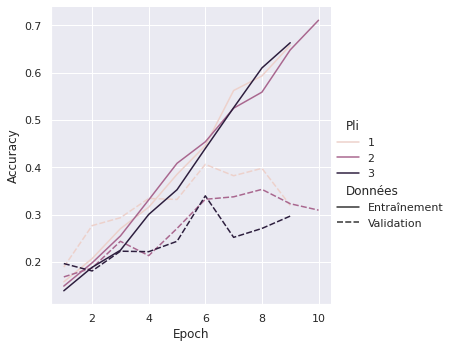

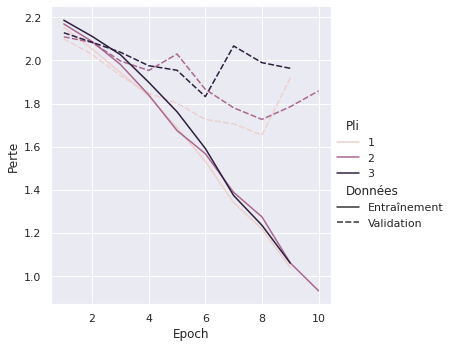

In [122]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = tokenized_data['test']['label']
labels = tokenized_data['test'].features['label'].names

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    labels_for_fig = [l[0:4]+'.' for l in labels]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=labels_for_fig)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Fonction qui retourne la perte (entropie croisée) et la classe prédite
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# Conversion des données au bon format
tokenized_data.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Calcul des valeurs de perte
tokenized_data["test"] = tokenized_data["test"].map(
    forward_pass_with_label, batched=True, batch_size=64)

In [ ]:
# Création d'un DataFrame avec les textes, les pertes les classe (prédites et attendues)

def label_int2str(row):
    return tokenized_data["train"].features["label"].int2str(row)

tokenized_data.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = tokenized_data["test"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
# Pour éviter l'affichage tronqué des descriptions
pd.set_option('display.max_colwidth', -1)
# Affichage des 10 premières instances triées par perte décroissante
df_test.sort_values("loss", ascending=False).head(10)

In [ ]:
# Affichage des 10 premières instances triées par perte croissante
# Cela permet de voir les instances pour lesquelles les prédictions sont les plus certaines
df_test.sort_values("loss", ascending=True).head(10)